In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [ ]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import torch.utils.data as data
import matplotlib.image as mpimg
from torchvision import transforms
from torchvision.utils import save_image


class MVTEC(data.Dataset):
    """`MVTEC <https://www.mvtec.com/company/research/datasets/mvtec-ad/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directories
            ``bottle``, ``cable``, etc., exists.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        resize (int, optional): Desired output image size.
        interpolation (int, optional): Interpolation method for downsizing image.
        category: bottle, cable, capsule, etc.
    """


    def __init__(self, root, train=True,
                 transform=None, target_transform=None,
                 category='bottle', resize=None, interpolation=2):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.resize = resize
        self.interpolation = interpolation
        
        # load images for training
        if self.train:
            self.train_data = []
            self.train_labels = []
            cwd = os.getcwd()
            trainFolder = self.root+'/'+category+'/train/good/'
            os.chdir(trainFolder)
            filenames = [f.name for f in os.scandir()]
            for file in filenames:
                img = mpimg.imread(file)
                img = img*255
                img = img.astype(np.uint8)
                self.train_data.append(img)
                self.train_labels.append(1)                 
            os.chdir(cwd)
                
            self.train_data = np.array(self.train_data)      
        else:
        # load images for testing
            self.test_data = []
            self.test_labels = []
            self.class_name = []
            
            cwd = os.getcwd()
            testFolder = self.root+'/'+category+'/test/'
            os.chdir(testFolder)
            subfolders = [sf.name for sf in os.scandir() if sf.is_dir()]
            cwsd = os.getcwd()
            
            # for every subfolder in test folder
            for subfolder in subfolders:
                label = 0
                if subfolder == 'good':
                    label = 1
                testSubfolder = './'+subfolder+'/'
                os.chdir(testSubfolder)
                filenames = [f.name for f in os.scandir()]
                for file in filenames:
                    img = mpimg.imread(file)
                    img = img*255
                    img = img.astype(np.uint8)
                    self.test_data.append(img)
                    self.test_labels.append(label)
                    self.class_name.append(subfolder)
                os.chdir(cwsd)
            os.chdir(cwd)
                
            self.test_data = np.array(self.test_data)
                
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)
        
        #if resizing image
        if self.resize is not None:
            resizeTransf = transforms.Resize(self.resize, self.interpolation)
            img = resizeTransf(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target

    def __len__(self):
        """
        Args:
            None
        Returns:
            int: length of array.
        """
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)


In [ ]:


transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 70

# Original images are high resolution, so we resize them using the transformation
# provided by pytorch: https://pytorch.org/vision/stable/transforms.html
im_shape = 256

# Interpolation method for resizing the image
interpol = 3



trainset = MVTEC(root='./datasets', 
                    train=True, 
                    transform=transform,
                    resize=im_shape, 
                    interpolation=interpol)
testset = MVTEC(root='./datasets', 
                   train=False, 
                   transform=transform,
                   resize=im_shape, 
                   interpolation=interpol)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=1,
                                         shuffle=False)

classes = ('defective', 'good')


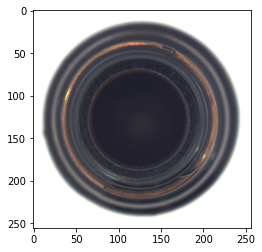

good


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get a random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(images[0])
# print label
print(classes[labels[0]])

In [ ]:
class decoder(nn.Module):
    def __init__(self, img_shape, latent_dim):
        super().__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            # State (100x1x1)
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.LeakyReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(True),

            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(True),

            # State (128x32x32)
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(True),

            # State (64x64x64)
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(True),

            # State (32x128x128)
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, input):
        img = self.model(input)
        return img.view(img.shape[0], *self.img_shape)


class encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            # State (3x256x256)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(16, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (16x128x128)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(32, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (32x64x64)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (64x32x32)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (128x16x16)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x8x8)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x4x4)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=1, padding=0)
            # output of main module --> State (1024x1x1)
        )

        self.last_layer = nn.Sequential(
            nn.Linear(1024, latent_dim),
            nn.Linear(latent_dim, latent_dim)
        )


    def forward(self, img):
        features = self.model(img)
        features = features.view(img.shape[0], -1)
        features = self.last_layer(features)
        features = features.view(features.shape[0], -1, 1, 1)
        return features

In [ ]:
encoder = encoder(1024)
decoder = decoder((3,256,256),1024)

In [ ]:
learning_rate = 0.001
num_epochs = 1500

criterion = nn.MSELoss()
encoder_optimizer = torch.optim.Adam( encoder.parameters(), lr=learning_rate, weight_decay=1e-5)
decoder_optimizer = torch.optim.Adam( decoder.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
num_epochs = 300
for epoch in range(num_epochs):
    for (img,label) in trainloader:
        # ===================forward=====================
        latent_z = encoder(img)
        output = decoder(latent_z)
        # ===================backward====================
        loss = criterion(output, img)
 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
    # ===================log========================
    if (epoch + 1) % 2 == 0:    
        print('epoch [{}/{}], loss:{:.4f}' .format(epoch + 1, num_epochs, float(loss.data) ))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


epoch [2/300], loss:0.1347
epoch [4/300], loss:0.0750
epoch [6/300], loss:0.0558
epoch [8/300], loss:0.0475
epoch [10/300], loss:0.0403
epoch [12/300], loss:0.0361
epoch [14/300], loss:0.0328
epoch [16/300], loss:0.0293
epoch [18/300], loss:0.0275
epoch [20/300], loss:0.0251
epoch [22/300], loss:0.0239
epoch [24/300], loss:0.0233
epoch [26/300], loss:0.0224
epoch [28/300], loss:0.0232
epoch [30/300], loss:0.0199
epoch [32/300], loss:0.0198
epoch [34/300], loss:0.0187
epoch [36/300], loss:0.0181
epoch [38/300], loss:0.0175
epoch [40/300], loss:0.0176
epoch [42/300], loss:0.0165
epoch [44/300], loss:0.0169
epoch [46/300], loss:0.0168
epoch [48/300], loss:0.0159
epoch [50/300], loss:0.0155
epoch [52/300], loss:0.0156
epoch [54/300], loss:0.0152
epoch [56/300], loss:0.0152
epoch [58/300], loss:0.0147
epoch [60/300], loss:0.0195
epoch [62/300], loss:0.0207
epoch [64/300], loss:0.0193
epoch [66/300], loss:0.0154
epoch [68/300], loss:0.0150
epoch [70/300], loss:0.0145
epoch [72/300], loss:0.0

In [ ]:
torch.save(encoder.state_dict(), './encoder_new.pth')
torch.save(decoder.state_dict(), './decoder_new.pth')

In [ ]:
encoder.load_state_dict(torch.load('./encoder_new.pth'))
decoder.load_state_dict(torch.load('./decoder_new.pth'))

<All keys matched successfully>

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [ ]:
testset.class_name

['contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'contamination',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_large',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_small',
 'broken_s

In [ ]:
x_test_orig = testset.test_data
y_test_orig = testset.test_labels

# check trained autoencoder image quality

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
generated_image = decoder(encoder(images))

In [ ]:
generated_image = generated_image.detach().numpy()

In [ ]:
save_image(images[:25], 'original_image.png', nrow=5, normalize=True)

In [ ]:
save_image(generated_image[:25], 'generated_image.png', nrow=5, normalize=True)

# Results

In [ ]:
encoder.eval()
decoder.eval()

anomaly_score = []
for (img,label) in testloader:
    # ===================forward=====================
    latent_z = encoder(img)
    output = decoder(latent_z )
    # ===================backward====================
    loss = criterion(output, img)
#     print(loss.cpu().tolist())
    anomaly_score += [loss.cpu().tolist()]

In [ ]:
y_test_orig = np.array(y_test_orig)
anomaly_score = np.array(anomaly_score)

In [ ]:
y_test_orig

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

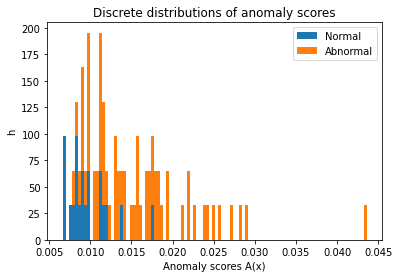

In [ ]:
plt.hist([anomaly_score[(y_test_orig) == 1], anomaly_score[(y_test_orig) == 0]],
          bins=100, density=True, stacked=True,
          label=["Normal", "Abnormal"])
plt.title("Discrete distributions of anomaly scores")
plt.xlabel("Anomaly scores A(x)")
plt.ylabel("h")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve,  precision_recall_curve, auc

In [ ]:
fpr, tpr, _ = roc_curve(y_test_orig, anomaly_score, pos_label=0)
precision, recall, _ = precision_recall_curve(y_test_orig, anomaly_score, pos_label=0)
roc_auc = auc(fpr, tpr)
pr_auc =  auc(recall, precision)

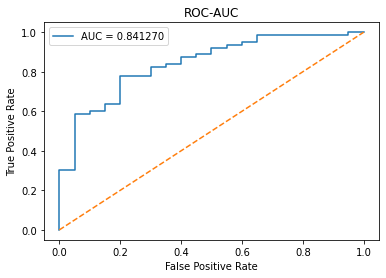

In [ ]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

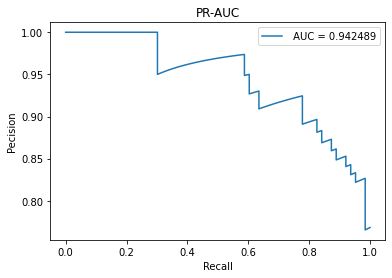

In [ ]:
plt.plot(recall, precision, label=f" AUC = {pr_auc:3f}")
plt.title("PR-AUC")
plt.xlabel("Recall")
plt.ylabel("Pecision")
plt.legend()
plt.show()

Visualization

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
generated_image = decoder(encoder(images))

In [ ]:
generated_image = generated_image.detach().numpy()

In [ ]:
for i, (img,label) in enumerate(testloader):
  real_img = img
  latent_z = encoder(real_img)
  fake_img = decoder(latent_z)

  compared_images = torch.empty(real_image.shape[0]*3, real_img.shape[1:])

  compared_images[0::3] = real_img
  compared_images[1::3] = fake_img
  compared_images[2::3] = real_img-fake_img

  label = label.cpu().tolist()
  cls_data_name = f'{testset.class_name[2*i]}_{testset.class_name[2*i+1]}'
  save_image(compared_image.data, f"images_diff/{cls_data_name}_{n_grid_lines*(i+1):06}.png", nrow=3,normalize =True)
